# Pre-trained ResNet and Transfer Learning

As a pre-requisite for implementing Faster R-CNN, we need to make sure that we can put new layers on top of a pre-trained backbone. Here we'll just use ResNet-50, trained on ImageNet, with a pre-trained model obtained from the TensorFlow GitHub. The specific version we'd like to use is the fully pre-activated variant as described in *Identity Mappings in Deep Residual Networks*. The goal of this notebook is to demonstrate:

 1. Loading the pre-trained model and testing out its accuracy on ImageNet
 2. Changing the final layer of the model and using it to classify a new dataset (transfer learning)

This is also a good opportunity to get comfortable with using the TFRecords dataset API, since now that we're putting on our big-boy pants and moving away from CIFAR-10 we'll no longer be able to just load the whole dataset in RAM at one time.

### *Important Note:*
The version of ResNet used to make this pre-trained checkpoin is *not* identical to that used in the original papers by Kaiming He (verified by looking at his GitHub and at the official TensorFlow models). Specifically, when we do downsampling in the residual blocks the strided convolution is done in the *middle* 3x3 convolutional layer, not the first 1x1 convolution.

No clue why this is done the way it is, actually, but the filters are all the same size so it's not clear at first what's going on. As far as I can tell, the accuracy and predictions of the model aren't really changed a drastic amount by this, but it seems marginally more accurate if the network is replicated exactly. I guess it makes some sense to delay downsampling as long as possible.

Also important: the trained model uses images in the RGB format, with all pixels ranged from 0-255 (about $\pm$ 128 after subtracting the per-channel means). This is worth noting since some implementations scale the images from -1 to 1 or something similar. That's enough of a scale difference that you'll get bizarre predictions out of the network if you accidentally do it (or if some function like the `rescale` function in `scikit-image` does it for you).

In [ ]:
from custom_session_run_hooks import CustomCheckpointSaverHook
from imagenet_labels import get_imagenet_label
from model import ResNet
import matplotlib.pyplot as plt
import numpy as np
import random
from resnet_var_dict import resnet_var_dict
import skimage
from skimage import io, transform
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

In [2]:
tf.logging.set_verbosity(tf.logging.WARN)

## Examining the pre-trained checkpoint
First, let's crack open this pre-trained checkpoint file and look at the weights. The simplest thing is to just look at all the tensors. We'll just print all their names; we don't really care specifically about individual tensor weights.

In [3]:
pre_trained_ckpt = './resnet_v2_imagenet_checkpoint/model.ckpt-250200'
print_tensors_in_checkpoint_file(pre_trained_ckpt, '', all_tensors=False, all_tensor_names=True)

tensor_name:  global_step
tensor_name:  resnet_model/batch_normalization/beta
tensor_name:  resnet_model/batch_normalization/beta/Momentum
tensor_name:  resnet_model/batch_normalization/gamma
tensor_name:  resnet_model/batch_normalization/gamma/Momentum
tensor_name:  resnet_model/batch_normalization/moving_mean
tensor_name:  resnet_model/batch_normalization/moving_variance
tensor_name:  resnet_model/batch_normalization_1/beta
tensor_name:  resnet_model/batch_normalization_1/beta/Momentum
tensor_name:  resnet_model/batch_normalization_1/gamma
tensor_name:  resnet_model/batch_normalization_1/gamma/Momentum
tensor_name:  resnet_model/batch_normalization_1/moving_mean
tensor_name:  resnet_model/batch_normalization_1/moving_variance
tensor_name:  resnet_model/batch_normalization_10/beta
tensor_name:  resnet_model/batch_normalization_10/beta/Momentum
tensor_name:  resnet_model/batch_normalization_10/gamma
tensor_name:  resnet_model/batch_normalization_10/gamma/Momentum
tensor_name:  resnet_m

Okay, a lot of stuff here, but it all seems in order. Note that we have 53 convolutional kernels. Looking back at the original ResNet paper, the convolutional blocks account for 48 layers. However, recall we have the initial $7\times7$ convolution, and each residual stage has a convolution on the first shortcut connection, to expand the number of channels (and possibly downsample). We've also got 49 batch normalization layers: 1 for the pre-activation for all 48 convolutional layers in the residual blocks, and one final batch-norm before the global average pool and FC layer.

It all checks out, now let's make sure we understand which layer is which. We'll pick some weights and check that they have the size we expect.

In [9]:
reader = pywrap_tensorflow.NewCheckpointReader(pre_trained_ckpt)
var_to_shape_map = reader.get_variable_to_shape_map()
def print_var_shape(var_name):
    print(var_name,':',var_to_shape_map[var_name])

Obviously the first convolutional layer should be the $7\times7$ filter which expands us from 3 to 64 channels. The next one after that should be the shortcut connection on the first block of the residual stage, which is a 1x1 kernel going from 64 to 256 channels.

In [5]:
print_var_shape('resnet_model/conv2d/kernel')
print_var_shape('resnet_model/conv2d_1/kernel')

resnet_model/conv2d/kernel : [7, 7, 3, 64]
resnet_model/conv2d_1/kernel : [1, 1, 64, 256]


So far, so good. Okay, the next 9 kernels should repeat the pattern: $1\times1\times256\times64$, $3\times3\times64\times64$, $1\times1\times64\times256$, three times.

In [6]:
for idx in range(2, 11):
    print_var_shape('resnet_model/conv2d_'+str(idx)+'/kernel')

resnet_model/conv2d_2/kernel : [1, 1, 64, 64]
resnet_model/conv2d_3/kernel : [3, 3, 64, 64]
resnet_model/conv2d_4/kernel : [1, 1, 64, 256]
resnet_model/conv2d_5/kernel : [1, 1, 256, 64]
resnet_model/conv2d_6/kernel : [3, 3, 64, 64]
resnet_model/conv2d_7/kernel : [1, 1, 64, 256]
resnet_model/conv2d_8/kernel : [1, 1, 256, 64]
resnet_model/conv2d_9/kernel : [3, 3, 64, 64]
resnet_model/conv2d_10/kernel : [1, 1, 64, 256]


Next one should be the first shortcut on the second residual stage ($1\times1\times256\times512$), and so on.

In [7]:
print_var_shape('resnet_model/conv2d_11/kernel')

resnet_model/conv2d_11/kernel : [1, 1, 256, 512]


Great, so we know exactly how to map this checkpoint onto the ResNet-50 layers.

## Pre-trained ResNet-50
Now let's just try to load up the existing pre-trained model and evaluate some images; no transfer learning just yet.

In [4]:
def model_fn_pretrained(features, labels, mode, params, config):
    """Model function for use with a TensorFlow Estimator, implementing a 
    ResNet-50 architecture, using pre-trained weights, trained with SGD w/Momentum.

    Parameters
    ----------
    features : Tensor or dictionary
        Feature or dictionary mapping names to feature Tensors.
    labels : Tensor or dictionary
        Label for the feature, or dictionary mapping names to label Tensors.
    mode : string
        ModeKey specifying whether we are in training/evaluation/prediction mode.
    params : dictionary
        Hyperparameters for the model.
    config : config object
        Runtime configuration of the Estimator calling us. Used to set up custom
        saver hooks

    Returns
    -------
    EstimatorSpec
    """
    data_format = params.get('data_format', 'channels_first')
    model = ResNet(data_format, num_blocks=[3, 4, 6, 3])
    image = features
    if isinstance(image, dict):
        image = features['image']

    dummy_train = params.get('dummy_train', False)
    training = mode is tf.estimator.ModeKeys.TRAIN and not dummy_train
    logits = model(image, training=training)
    
    classes = tf.argmax(logits, axis=1, output_type=tf.int32, name='predictions')

    if mode is tf.estimator.ModeKeys.PREDICT:
        predictions = {'classes': classes, 'probabilities': tf.nn.softmax(logits)}
        return tf.estimator.EstimatorSpec(
            mode=mode, predictions=predictions)

    with tf.name_scope('loss_op'):
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits) \
              +tf.losses.get_regularization_loss()
    tf.summary.scalar('loss', loss)

    accuracy = tf.metrics.accuracy(labels=labels, 
                                   predictions=classes, name='accuracy_op')
    tf.summary.scalar('accuracy', accuracy[1])

    if mode is tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, 
                                          eval_metric_ops={'accuracy': accuracy})
    
    pre_trained_ckpt = params.get('pre_trained_ckpt', None)
    if pre_trained_ckpt is not None:
        tf.train.init_from_checkpoint(pre_trained_ckpt, resnet_var_dict)

    learning_rate = params.get('learning_rate', 0.01)
    momentum = params.get('momentum', 0.9)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    global_step = tf.train.get_or_create_global_step()
    with tf.name_scope('train'):
        if isinstance(learning_rate, list):
            boundaries = learning_rate[0]
            values = learning_rate[1]
            learn_rate = tf.train.piecewise_constant(
                global_step, boundaries, values)
        else:
            learn_rate = learning_rate
        optimizer = tf.train.MomentumOptimizer(
            learning_rate=learn_rate, momentum=momentum, use_nesterov=True)

        with tf.control_dependencies(extra_update_ops):
            train_op = optimizer.minimize(loss, global_step)

    train_spec = tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Use a custom checkpoint saver hook to avoid saving the graph definition 
    # every single checkpoint
    save_hook = CustomCheckpointSaverHook(
        config.model_dir, save_secs=config.save_checkpoints_secs,
        save_steps=config.save_checkpoints_steps, scaffold=train_spec.scaffold)
    train_spec = train_spec._replace(training_chief_hooks=[save_hook])

    return train_spec

Now, I rather like having the different residual blocks separated into different namespaces, since it makes the graph look like a bit less of a mess in TensorFlow. Of course, due to this we can't just load the pre-trained checkpoint wholesale. That's okay, however, we just need a dictionary that maps namespaces in one model to the other (since we know there is one-to-one correspondence for all the tensors).

To check that this is working, let's make a dummy estimator with a randomly initialized model, "train" it so we get a and check the mapping is correct in our dictionary (at least in terms of all the mappings preserving tensor shape).

In [9]:
params = {'data_format': 'channels_last'}
estimator = tf.estimator.Estimator(model_fn_pretrained, model_dir='logs/test', params=params, 
                                   config=tf.estimator.RunConfig(keep_checkpoint_max=1))

In [10]:
rand_data = np.random.randint(0, 256, (32, 224, 224, 3)).astype('float32')
rand_labels = np.random.randint(0, 1000, 32).astype('int32')
input_fn = tf.estimator.inputs.numpy_input_fn(rand_data, y=rand_labels, shuffle=False, batch_size=32)

In [ ]:
estimator.train(input_fn)

In [11]:
reader = pywrap_tensorflow.NewCheckpointReader('./logs/pre_trained/model.ckpt-1')
new_var_to_shape_map = reader.get_variable_to_shape_map()
# print_tensors_in_checkpoint_file('./logs/test/model.ckpt-1', '', all_tensors=False, all_tensor_names=True)

In [13]:
# This should print nothing if the mapping is good
for old_base_name, new_base_name in resnet_var_dict.items():
    old_var_names = [var_name for var_name in var_to_shape_map if old_base_name in var_name]
    new_var_names = [new_base_name+var_name.replace(old_base_name, '') for var_name in old_var_names]
    for old_name, new_name in zip(old_var_names, new_var_names):
        if var_to_shape_map[old_name] != new_var_to_shape_map[new_name]:
            print(old_name,'has a different shape than',new_name)

Perfect. Now, let's make an estimator which loads all tensor values from the pre-trained model, and test it out on some images. Of course, the downside of using the Estimator is that to predict or evaluate we actually need to have a checkpoint in the model directory, even if all variables are initialized in the model function setup.

More annoyingly, we *can't* just specify the pre-trained checkpoint at setup and run a dummy training run. The reason? Even though the learning rate can be set to 0 to avoid changing the trainable parameters, this will screw up the moving mean and variance of the batch-norm layers.

Because I'm feeling lazy, we're going to do the super-dumb thing and define an extra parameter `dummy_train`, which will tell the model that we're not *really* training. That way, we don't pass the `training` flag to the model and the batch-norm layers will not be updated. This is...really, *really* ugly, but it will work for now.

In [5]:
params = {'data_format': 'channels_last', 'pre_trained_ckpt': pre_trained_ckpt, 'learning_rate': 0.0, 'dummy_train': True}
estimator = tf.estimator.Estimator(model_fn_pretrained, model_dir='logs/pre_trained', params=params, 
                                   config=tf.estimator.RunConfig(keep_checkpoint_max=1))

In [8]:
rand_data = np.random.randint(0, 256, (32, 224, 224, 3)).astype('float32')
rand_labels = np.random.randint(0, 1000, 32).astype('int32')
input_fn = tf.estimator.inputs.numpy_input_fn(rand_data, y=rand_labels, shuffle=False, batch_size=32)
estimator.train(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/beta
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/gamma
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block/bn_2/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_1/beta
INFO:tensorflow:Initialize variable res_net/res_block/bn_2/ga

INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/beta
INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/gamma
INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block/bn_3/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_2/beta
INFO:tensorflow:Initialize variable res_net/res_block/bn_3/gamma from check

INFO:tensorflow:Initialize variable res_net/res_block_9/bn_2/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_28/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/beta
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/gamma
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/moving_variance
INFO:tensorflow:Initialize variable res_net/res_bl

INFO:tensorflow:Initialize variable res_net/res_block_12/bn_3/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_38/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block_13/bn_1/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_39/beta
INFO:tensorflow:Initialize variable res_net/res_block_13/bn_1/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_39/gamma
INFO:tensorflow:Initialize variable res_net/res_block_13/bn_1/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_39/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_13/bn_1/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_39/moving_variance
INFO:tensorflow:Initialize variable res_net/r

INFO:tensorflow:Initialize variable res_net/bn_final/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_48/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_3/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_5/beta
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_3/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_5/gamma
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_3/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_5/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_3/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_5/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block_2/bn_1/b

INFO:tensorflow:Initialize variable res_net/res_block_9/conv_2/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_32/kernel
INFO:tensorflow:Initialize variable res_net/res_block_9/conv_3/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_33/kernel
INFO:tensorflow:Initialize variable res_net/res_block_10/conv_1/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_34/kernel
INFO:tensorflow:Initialize variable res_net/res_block_10/conv_2/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_35/kernel
INFO:tensorflow:Initialize variable res_net/res_block_10/conv_3/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_36/kernel
INFO:tensorflow:Initialize variable res_net/res_block_11/conv_1/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with 

First, the dumbest type of check, let's just see how different the tensors are. It's not hard to double check every tensor in the model, excluding those used for training. This should yield exactly 0 for each tensor.

In [12]:
old_reader = pywrap_tensorflow.NewCheckpointReader(pre_trained_ckpt)
new_reader = pywrap_tensorflow.NewCheckpointReader('logs/pre_trained/model.ckpt-1')

for old_base_name, new_base_name in resnet_var_dict.items():
    old_var_names = [var_name for var_name in var_to_shape_map if old_base_name in var_name]
    new_var_names = [new_base_name+var_name.replace(old_base_name, '') for var_name in old_var_names]
    for old_name, new_name in zip(old_var_names, new_var_names):
        if 'Momentum' in old_name:
            continue # Don't care about training variables here
        old_var = old_reader.get_tensor(old_name)
        new_var = new_reader.get_tensor(new_name)
        norm = np.linalg.norm(old_var-new_var)
        print('|%s - %s|: %.2f' % (old_name, new_name, norm))

|resnet_model/batch_normalization/beta - res_net/res_block/bn_1/beta|: 0.00
|resnet_model/batch_normalization/gamma - res_net/res_block/bn_1/gamma|: 0.00
|resnet_model/batch_normalization/moving_variance - res_net/res_block/bn_1/moving_variance|: 0.00
|resnet_model/batch_normalization/moving_mean - res_net/res_block/bn_1/moving_mean|: 0.00
|resnet_model/batch_normalization_1/moving_mean - res_net/res_block/bn_2/moving_mean|: 0.00
|resnet_model/batch_normalization_1/beta - res_net/res_block/bn_2/beta|: 0.00
|resnet_model/batch_normalization_1/gamma - res_net/res_block/bn_2/gamma|: 0.00
|resnet_model/batch_normalization_1/moving_variance - res_net/res_block/bn_2/moving_variance|: 0.00
|resnet_model/batch_normalization_2/beta - res_net/res_block/bn_3/beta|: 0.00
|resnet_model/batch_normalization_2/gamma - res_net/res_block/bn_3/gamma|: 0.00
|resnet_model/batch_normalization_2/moving_mean - res_net/res_block/bn_3/moving_mean|: 0.00
|resnet_model/batch_normalization_2/moving_variance - res_

|resnet_model/conv2d_37/kernel - res_net/res_block_11/conv_1/kernel|: 0.00
|resnet_model/conv2d_38/kernel - res_net/res_block_11/conv_2/kernel|: 0.00
|resnet_model/conv2d_39/kernel - res_net/res_block_11/conv_3/kernel|: 0.00
|resnet_model/conv2d_40/kernel - res_net/res_block_12/conv_1/kernel|: 0.00
|resnet_model/conv2d_41/kernel - res_net/res_block_12/conv_2/kernel|: 0.00
|resnet_model/conv2d_42/kernel - res_net/res_block_12/conv_3/kernel|: 0.00
|resnet_model/conv2d_43/kernel - res_net/res_block_13/conv_0/kernel|: 0.00
|resnet_model/conv2d_44/kernel - res_net/res_block_13/conv_1/kernel|: 0.00
|resnet_model/conv2d_45/kernel - res_net/res_block_13/conv_2/kernel|: 0.00
|resnet_model/conv2d_46/kernel - res_net/res_block_13/conv_3/kernel|: 0.00
|resnet_model/conv2d_47/kernel - res_net/res_block_14/conv_1/kernel|: 0.00
|resnet_model/conv2d_48/kernel - res_net/res_block_14/conv_2/kernel|: 0.00
|resnet_model/conv2d_49/kernel - res_net/res_block_14/conv_3/kernel|: 0.00
|resnet_model/conv2d_50/k

Perfect. Next check is to test some images on this network. Now, in principle I could go grab the ILSVRC 2012 dataset, but that requires signing up and making a request with a non-GMail account and...meh.

Let's do something a little more fun. I will just throw it some images and let's see what pops out! First we'll feed in actual ImageNet images. It better get these right...

In [6]:
imagenet_mean = 255*np.array([0.485, 0.456, 0.406], dtype='float32') # mean RGB values on the training set
def resnet_test(image_path):
    real_picture = io.imread(image_path).astype('float32')
    test_image = real_picture-imagenet_mean[None, None, :]
    input_fn = tf.estimator.inputs.numpy_input_fn(test_image[None, :], y=np.array([0]), shuffle=False)
    prediction = estimator.predict(input_fn)
    prob_dict = prediction.__next__()
    
    class_idxs = np.flipud(np.argsort(prob_dict['probabilities'])[-5:])
    class_probs = 100*prob_dict['probabilities'][class_idxs]
    cell_text = [['%.1f%%' % x for x in class_probs]]
    class_labels = [get_imagenet_label(x) for x in class_idxs]
    
    plt.figure(figsize=(6,6))
    plt.imshow(real_picture.astype('int32'))
    plt.axis('off')
    table = plt.table(cellText=cell_text, colLabels=class_labels,
                      loc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(2, 2)
    plt.show()

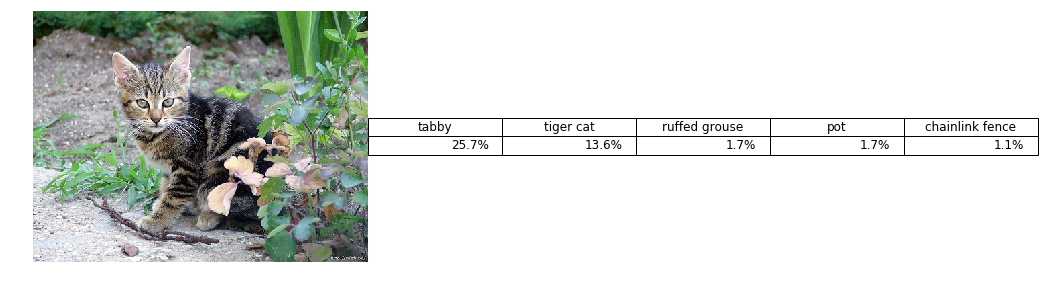

In [7]:
resnet_test('./example_data/imagenet_tabby_cat_1.jpg')

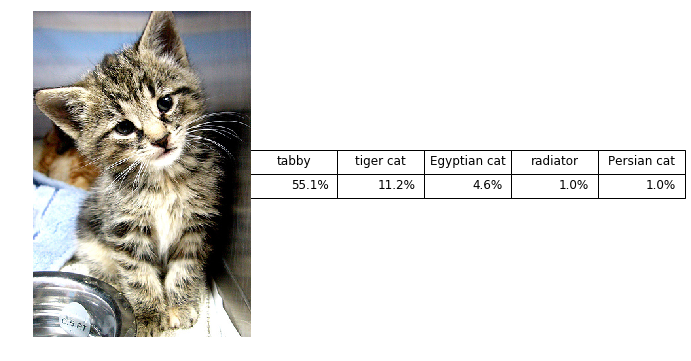

In [8]:
resnet_test('./example_data/imagenet_tabby_cat_2.jpg')

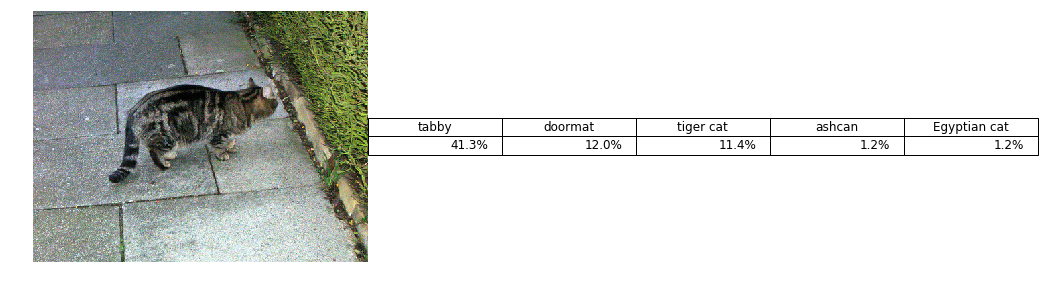

In [9]:
resnet_test('./example_data/imagenet_tabby_cat_3.jpg')

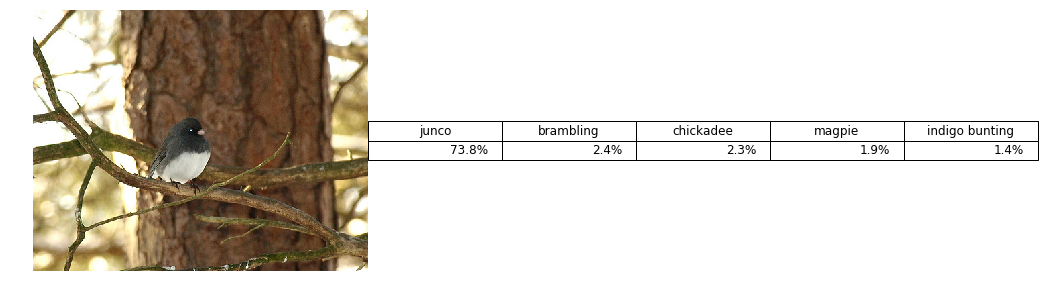

In [10]:
resnet_test('./example_data/imagenet_junco_1.jpg')

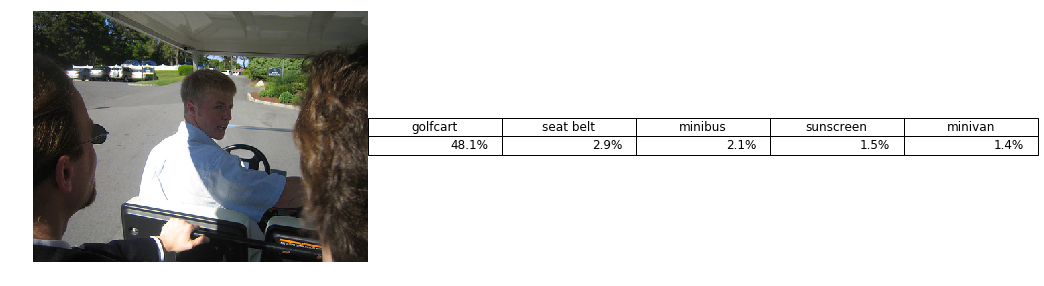

In [11]:
resnet_test('./example_data/imagenet_golf_cart_1.jpg')

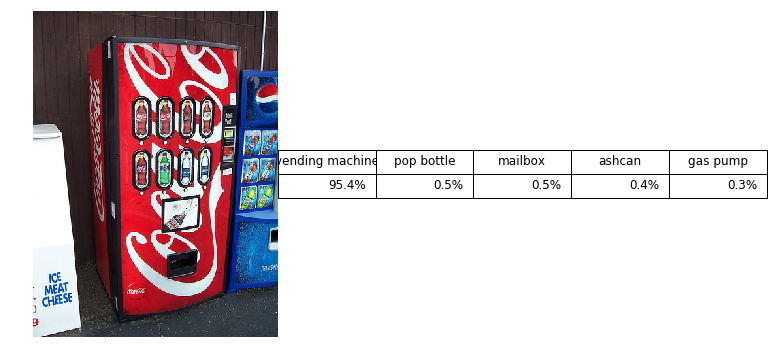

In [12]:
resnet_test('./example_data/imagenet_vending_machine_1.jpg')

Outstanding. Now, how about some *non*-ImageNet images?

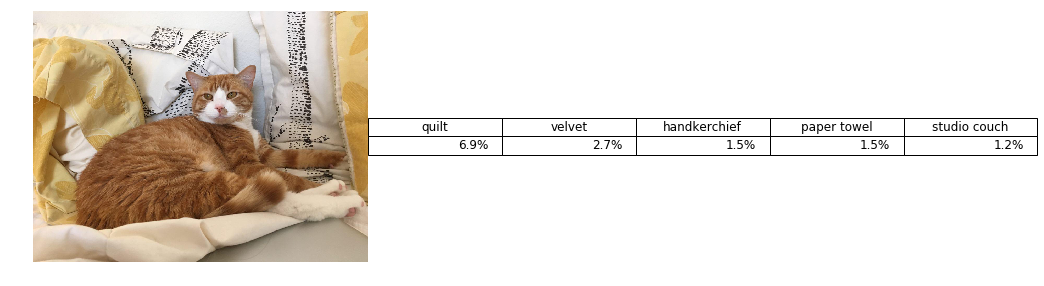

In [13]:
resnet_test('./example_data/cute_cat_1.jpg')

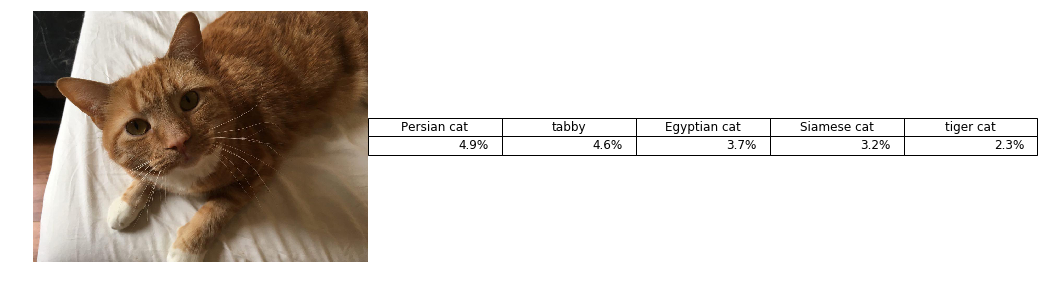

In [14]:
resnet_test('./example_data/cute_cat_2.jpg')

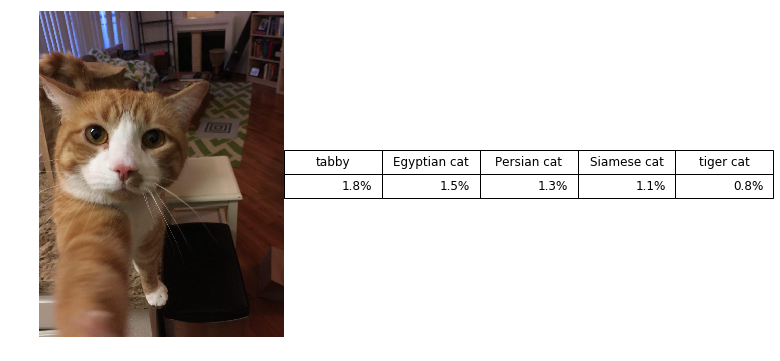

In [15]:
resnet_test('./example_data/cute_cat_3.jpg')

Wow. It's not great at identifying my cats as tabby cats. Is it because they are orange? Maybe ImageNet doesn't have many orange tabby cat pictures? That seems superficially true based on a quick perusal of their image browser; most of the tabby pictures are of gray tabby cats. Must be keying in on color more than patterning. It seems to be reasonably okay at detecting that they are cats...

Maybe an image from the side? On Gus, especially this would show the classic tabby pattern.

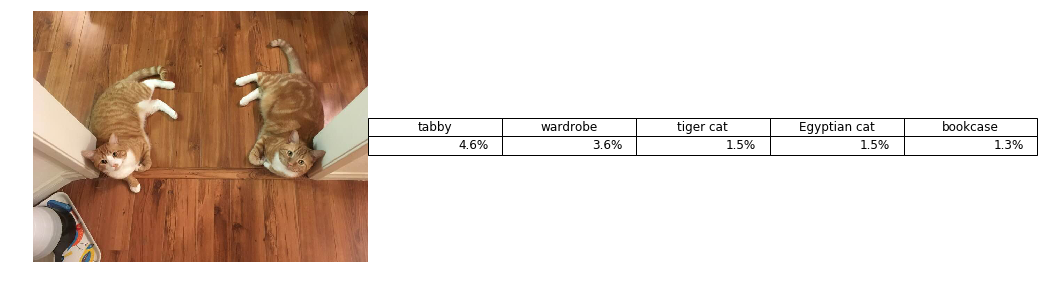

In [16]:
resnet_test('./example_data/cute_cat_4.jpg')

There it is!

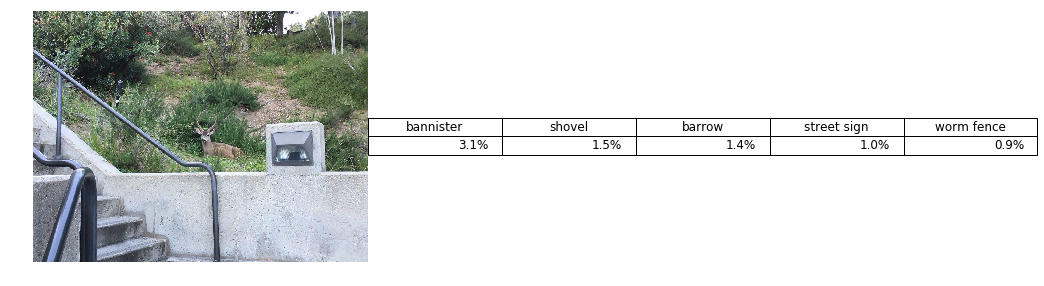

In [17]:
resnet_test('./example_data/deer_1.jpg')

That's...not wrong, I guess. Clearly the machine and I have very different ideas about what is constitutes the subject of a picture. WTF is a 'worm fence'?!